In [ ]:
#@title Kaggle Auth

import os

from google.colab import drive
from google.colab import userdata

drive.mount('/content/gdrive/')


os.environ['KAGGLE_USERNAME'] =  userdata.get('kaggle_username')
os.environ['KAGGLE_KEY'] = userdata.get('kaggle_token')

Mounted at /content/gdrive/


In [ ]:
!kaggle datasets download -d ryeltsin/finger-vein
!unzip finger-vein.zip

 91% 165M/181M [00:02<00:00, 95.8MB/s]
100% 181M/181M [00:02<00:00, 73.8MB/s]
Archive:  finger-vein.zip
  inflating: Finger Vein Database/001/left/Thumbs.db  
  inflating: Finger Vein Database/001/left/index_1.bmp  
  inflating: Finger Vein Database/001/left/index_2.bmp  
  inflating: Finger Vein Database/001/left/index_3.bmp  
  inflating: Finger Vein Database/001/left/index_4.bmp  
  inflating: Finger Vein Database/001/left/index_5.bmp  
  inflating: Finger Vein Database/001/left/index_6.bmp  
  inflating: Finger Vein Database/001/left/middle_1.bmp  
  inflating: Finger Vein Database/001/left/middle_2.bmp  
  inflating: Finger Vein Database/001/left/middle_3.bmp  
  inflating: Finger Vein Database/001/left/middle_4.bmp  
  inflating: Finger Vein Database/001/left/middle_5.bmp  
  inflating: Finger Vein Database/001/left/middle_6.bmp  
  inflating: Finger Vein Database/001/left/ring_1.bmp  
  inflating: Finger Vein Database/001/left/ring_2.bmp  
  inflating: Finger Vein Database/001/l

In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/skeletons_2.zip

Archive:  /content/gdrive/MyDrive/Dataset/skeletons_2.zip
   creating: all_v2/
  inflating: all_v2/001_leftflipped_index_1_skeleton.bmp  
  inflating: all_v2/001_leftflipped_index_2_skeleton.bmp  
  inflating: all_v2/001_leftflipped_index_3_skeleton.bmp  
  inflating: all_v2/001_leftflipped_index_4_skeleton.bmp  
  inflating: all_v2/001_leftflipped_index_5_skeleton.bmp  
  inflating: all_v2/001_leftflipped_index_6_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_1_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_2_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_3_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_4_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_5_skeleton.bmp  
  inflating: all_v2/001_leftflipped_middle_6_skeleton.bmp  
  inflating: all_v2/001_leftflipped_ring_1_skeleton.bmp  
  inflating: all_v2/001_leftflipped_ring_2_skeleton.bmp  
  inflating: all_v2/001_leftflipped_ring_3_skeleton.bmp  
  inflating: all_v2/001_leftflipp

In [ ]:
import torch
import random

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  42


In [ ]:
import glob
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

batch_size = 1
lr = 1e-5
lambda_cycle = 10
worker = 4
epochs = 50
ngpu = 1


FV3C_TRANSFORM = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
])


class DoubleFingerVeinDataset(Dataset):

    def __init__(self, data, data_p, transform=None):
        super(DoubleFingerVeinDataset, self).__init__()
        self.data = data
        self.data_p = data_p
        self.transform = transform

        if len(self.data) != len(self.data_p):
          raise ValueError('Inconsistent Length')

    def __len__(self):
        return len(self.data)

    @classmethod
    def load_from_dir(cls, data_dir, data_dir_p, transform=None):
        dir_list = glob.glob(data_dir)
        dir_list_p = glob.glob(data_dir_p)
        return cls(data=dir_list, data_p=dir_list_p, transform=transform)

    def to_dataloader(self, batch_size: int = 1, shuffle: bool = True, num_workers: int = 1):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        img_p = Image.open(self.data_p[idx]).convert('RGB')

        if self.transform:
            img = self.transform(img)
            img_p = self.transform(img_p)

        return img, img_p


dataset = DoubleFingerVeinDataset.load_from_dir(
    data_dir='Finger Vein Database/*/*/*.bmp',
    data_dir_p='all_v2/*.bmp',
    transform=FV3C_TRANSFORM
)

dataloader = dataset.to_dataloader(batch_size=batch_size, shuffle=True, num_workers=worker)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


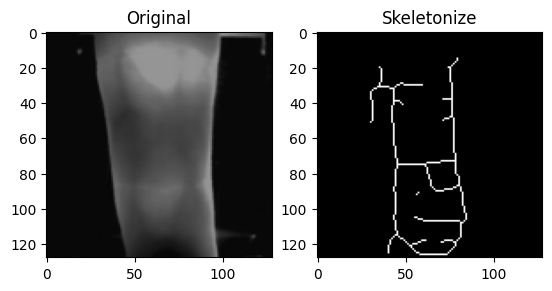

In [ ]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(dataset[0][0].T)
axarr[0].set_title('Original')
axarr[1].imshow(dataset[0][1].T)
axarr[1].set_title('Skeletonize')
plt.show()

In [ ]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return x

In [ ]:
import os

if not os.path.exists('outputs'):
  os.makedirs('outputs')

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(
    disc_H,
    disc_Z,
    gen_Z,
    gen_H,
    loader,
    opt_disc,
    opt_gen,
    l1,
    mse,
    d_scaler,
    g_scaler
):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (finger, skeleton) in enumerate(loop):
        finger = finger.to(device)
        skeleton = skeleton.to(device)

        # Train discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_skeleton = gen_H(finger)
            D_H_real = disc_H(skeleton)
            D_H_fake = disc_H(fake_skeleton.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_finger = gen_Z(skeleton)
            D_Z_real = disc_Z(finger)
            D_Z_fake = disc_Z(fake_finger.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_H_fake = disc_H(fake_skeleton)
            D_Z_fake = disc_Z(fake_finger)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle losses
            cycle_finger = gen_Z(fake_skeleton)
            cycle_skeleton = gen_H(fake_finger)
            cycle_finger_loss = l1(finger, cycle_finger)
            cycle_skeleton_loss = l1(skeleton, cycle_skeleton)

            # total loss
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_finger_loss * lambda_cycle
                + cycle_skeleton_loss * lambda_cycle
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_skeleton * 0.5 + 0.5, f"outputs/skeleton_{idx}.png")
            save_image(fake_finger * 0.5 + 0.5, f"outputs/finger_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

In [ ]:
disc_H = Discriminator(in_channels=3).to(device)
disc_Z = Discriminator(in_channels=3).to(device)
gen_Z = Generator(img_channels=3, num_residuals=9).to(device)
gen_H = Generator(img_channels=3, num_residuals=9).to(device)

In [ ]:
# use Adam Optimizer for both generator and discriminator
opt_disc = optim.Adam(
    list(disc_H.parameters()) + list(disc_Z.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_Z.parameters()) + list(gen_H.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [ ]:
for epoch in range(epochs):
  train_fn(
      disc_H,
      disc_Z,
      gen_Z,
      gen_H,
      dataloader,
      opt_disc,
      opt_gen,
      L1,
      mse,
      d_scaler,
      g_scaler,
)